In [1]:
import numpy as np
import os

from llmize import OPRO, HLMEA, HLMSA
import llmize

from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from google import genai

client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))

response = client.models.generate_content(
    model="gemma-3-1b-it",
    contents="Roses are red...",
)

print(response.text)

Roses are red,
Violets are blue,
Sugar is sweet,
And I’m feeling cute! 

Would you like me to continue the rhyme? Or perhaps you have a different request?


In [3]:
print(llmize.__version__)


0.2.0


In [4]:
def objective_convex_penalty(x):
    """
    Objective function for the Convex Optimization problem with penalties.
    The function is minimized.
    """
    x1, x2 = x
    f = (x1 - 3)**2 + (x2 + 2)**2 + np.sin(x1 + x2) + 4
    
    # Constraint violations
    penalty = 0
    large_penalty = 1e6  # Large penalty value

    if x1 < 0 or x1 > 5:
        penalty += large_penalty
    if x2 < 0 or x2 > 5:
        penalty += large_penalty

    return f + penalty

In [ ]:
# Generate random solutions (list of lists) and scores (list of floats)
num_samples = 2
batch_size = num_samples**2
x1_range = np.linspace(0, 4.5, num_samples)
x2_range = np.linspace(0, 4.5, num_samples)
solutions = []
scores = []
for i in range(num_samples):
    for j in range(num_samples):
        solutions.append([x1_range[i], x2_range[j]])
        scores.append(objective_convex_penalty([x1_range[i], x2_range[j]]))

print(solutions)
print(scores)
print(len(solutions), len(scores))

[[np.float64(0.0), np.float64(0.0)], [np.float64(0.0), np.float64(1.5)], [np.float64(0.0), np.float64(3.0)], [np.float64(0.0), np.float64(4.5)], [np.float64(1.5), np.float64(0.0)], [np.float64(1.5), np.float64(1.5)], [np.float64(1.5), np.float64(3.0)], [np.float64(1.5), np.float64(4.5)], [np.float64(3.0), np.float64(0.0)], [np.float64(3.0), np.float64(1.5)], [np.float64(3.0), np.float64(3.0)], [np.float64(3.0), np.float64(4.5)], [np.float64(4.5), np.float64(0.0)], [np.float64(4.5), np.float64(1.5)], [np.float64(4.5), np.float64(3.0)], [np.float64(4.5), np.float64(4.5)]]
[np.float64(17.0), np.float64(26.247494986604053), np.float64(38.141120008059865), np.float64(54.2724698823349), np.float64(11.247494986604053), np.float64(18.641120008059865), np.float64(30.272469882334903), np.float64(48.22058450180107), np.float64(8.141120008059868), np.float64(15.272469882334903), np.float64(28.720584501801074), np.float64(47.18799997677474), np.float64(9.272469882334903), np.float64(18.220584501801

In [6]:
with open("convex_problem.txt", "r") as f:
    problem_text = f.read()

# Initialize the OPRO optimizer
opro = OPRO(problem_text=problem_text, obj_func=objective_convex_penalty,
            llm_model="gemma-3-27b-it", api_key=os.getenv("GEMINI_API_KEY"))

prompt = opro.get_sample_prompt(init_samples=solutions, init_scores=scores, optimization_type="minimize")
response = opro.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)

Prompt:
Problem: Convex Optimization
-----------------------------------------------------
Objective: Minimize the function
    f(x1, x2) = (x1 - 3)^2 + (x2 + 2)^2 + sin(x1 + x2) + 4

Subject to constraints:
    0 ≤ x1 ≤ 5
    0 ≤ x2 ≤ 5
Below are some examples of solutions and their scores:

<sol> 0.0,0.0 <\sol>
score: 17.000

<sol> 0.0,1.5 <\sol>
score: 26.247

<sol> 0.0,3.0 <\sol>
score: 38.141

<sol> 0.0,4.5 <\sol>
score: 54.272

<sol> 1.5,0.0 <\sol>
score: 11.247

<sol> 1.5,1.5 <\sol>
score: 18.641

<sol> 1.5,3.0 <\sol>
score: 30.272

<sol> 1.5,4.5 <\sol>
score: 48.221

<sol> 3.0,0.0 <\sol>
score: 8.141

<sol> 3.0,1.5 <\sol>
score: 15.272

<sol> 3.0,3.0 <\sol>
score: 28.721

<sol> 3.0,4.5 <\sol>
score: 47.188

<sol> 4.5,0.0 <\sol>
score: 9.272

<sol> 4.5,1.5 <\sol>
score: 18.221

<sol> 4.5,3.0 <\sol>
score: 32.188

<sol> 4.5,4.5 <\sol>
score: 48.912


Generate exactly 5 new solutions that:
- Are distinct from all previous solutions.
- Have lower scores than the lowest provided.
- 

In [7]:
from llmize.callbacks import EarlyStopping, AdaptTempOnPlateau, OptimalScoreStopping

# Define the early stopping callback
earlystop_callback = EarlyStopping(monitor='best_score', min_delta=0.001, patience=50, verbose=1)

# Define the optimal score stopping callback
optimal_score_callback = OptimalScoreStopping(optimal_score=7.90, tolerance=0.01)

# Define the temperature adaptation callback
adapt_temp_callback = AdaptTempOnPlateau(monitor='best_score', init_temperature=1.0, min_delta=0.001, patience=20, factor=1.1, max_temperature=1.9, verbose=1)

callbacks = [earlystop_callback, optimal_score_callback, adapt_temp_callback]

In [ ]:
results = opro.minimize(init_samples=solutions, init_scores=scores, num_steps=250, batch_size=4, callbacks=callbacks)


Running OPRO optimization with 250 steps and batch size 16...
Step 0 - Best Initial Score: 8.141, Average Initial Score: 28.247
Step 1 - Current Best Score: 7.899, Average Batch Score: 10.251 - Best Batch Score: 7.899
No improvement in best_score. Patience count: 1/50
WARNING - Optimal score reached at step 1.
WARNING - Optimal score reached at step 1.
Execution time of minimize: 12.533 seconds


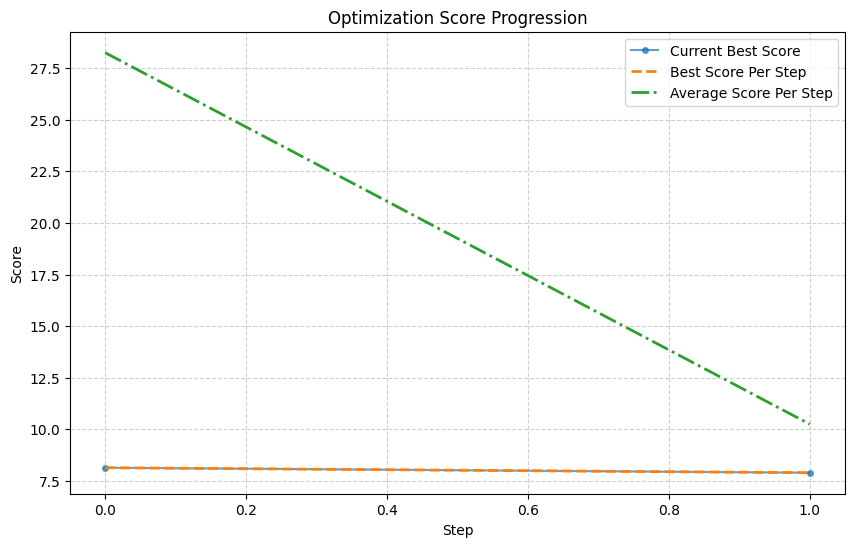

In [9]:
# add plotting here
from llmize.utils.plotting import plot_scores
plot_scores(results)
